In [1]:
import pandas as pd
import numpy as np

from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from PIL import Image
# import mpldatacursor

from PIL import Image
from PyPDF2 import PdfReader
from matplotlib.widgets import Cursor, SpanSelector

# import pytesseract
import easyocr
import keras_ocr
from keras_ocr.tools import drawAnnotations
import re
import os
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

### Extracting Images from the PDF

In [ ]:
def extract_images_from_pdf(pdf_path, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Load the PDF file
    pdf_reader = PdfReader(pdf_path)

    # Loop through each page of the PDF
    for page_number, page in enumerate(pdf_reader.pages):
        # Extract images from the page
        xObject = page['/Resources']['/XObject'].get_object()
        image_counter = 0

        for obj in xObject:
            if xObject[obj]['/Subtype'] == '/Image':
                size = (xObject[obj]['/Width'], xObject[obj]['/Height'])
                data = xObject[obj].get_object()

                if '/Filter' in data:
                    if data['/Filter'] == '/FlateDecode':
                        img = Image.frombytes('RGB', size, data.get_data())
                        img.save(os.path.join(output_folder, f"page_{page_number + 1}_image_{image_counter}.png"))
                        image_counter += 1
                    elif data['/Filter'] == '/DCTDecode':
                        img = open(os.path.join(output_folder, f"page_{page_number + 1}_image_{image_counter}.jpg"), "wb")
                        img.write(data.get_data())
                        img.close()
                        image_counter += 1


In [ ]:
pdf_file_path = "C:/Users/JubinMohanty/Desktop/OCR_models/data/Jewelosco.pdf"
output_image_folder_path = "C:/Users/JubinMohanty/Desktop/OCR_models\data\image"

extract_images_from_pdf(pdf_file_path, output_image_folder_path)

### Displaying the image

In [ ]:
image_files = glob('C:/Users/JubinMohanty/Desktop/OCR_models/data/image/*')
# Check if the image file exists
if os.path.exists(image_files[0]):
    # Load the image
    img = Image.open(image_files[0])

    # Create a single subplot for the image
    fig, ax = plt.subplots(figsize=(20, 20))

    # Display the image
    ax.imshow(img)
    ax.set_title(f'Single Image - {os.path.basename(image_files[0])}')
    ax.axis('off')

    # Show the plot
    plt.show()
else:
    print(f"Image not found: {image_files[0]}")

### EasyOCR

In [2]:
image_files = glob('C:/Users/pmehra/Desktop/ocr/Adhoc-image-project/output/*')

In [3]:
reader = easyocr.Reader(['en'], gpu = True)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


##### Performed some testing and analysis on images

In [ ]:
results = reader.readtext(image_files[8])

In [ ]:
# Create the DataFrame
bbox_df = pd.DataFrame(results, columns=['bbox', 'text', 'conf'])

In [ ]:
# Convert the 'text' column to lowercase and filter rows where the lowercase text starts with the strings
filtered_df = bbox_df[bbox_df['text'].str.lower().str.startswith(('digh', 'reb', 'digital', 'coup', 'dig'), na=False)]

In [ ]:
strings_list = ['digital rebate', 'digital coupon']

# Find the maximum length among the given strings
max_length = max(len(s) for s in strings_list)

In [ ]:
# Filter the DataFrame based on the maximum length
filtered_df = filtered_df[filtered_df['text'].str.len() <= max_length]

In [ ]:
filtered_df

In [ ]:
import re
img_id = image_files[12].split('\\')[1]
# Use regular expression to extract the number after "page_"
page_number = re.search(r'page_(\d+)', img_id).group(1)
filtered_df['page_number'] = page_number

In [ ]:
len(filtered_df['bbox'].values[0])

In [ ]:
filtered_df

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

easy_results = filtered_df[['text','bbox']].values.tolist()
# print(easy_results)

easy_results = [(x[0], np.array(x[1])) for x in easy_results]
# print(easy_results)

keras_ocr.tools.drawAnnotations(plt.imread(image_files[8]), easy_results, ax=ax)

ax.set_title('Easy OCR Result Example')

# Save the annotated image with improved quality
output_file = 'C:/Users/JubinMohanty/Desktop/OCR_models/data/output_easy_ocr/annotated_image.jpg'
plt.savefig(output_file, dpi=300)

plt.show()

#### Checking if the strings are close to one another , if yes then merge it
**Calculated the central distance**

In [ ]:
def horizontal_distance(bbox1, bbox2):
    x1, y1 = bbox1[0]
    x2, y2 = bbox1[1]
    x3, y3 = bbox2[0]
    x4, y4 = bbox2[1]

    center1_x = (x1 + x2) / 2
    center2_x = (x3 + x4) / 2
    return abs(center1_x - center2_x)

In [ ]:
filtered_df_copy = filtered_df.copy()

In [ ]:
# Group bounding boxes that are close horizontally and aggregate the 'text' column as a single string
grouped_text = []
grouped_conf = []
grouped_indices = []  # To keep track of already grouped indices
group_threshold = 20  # Adjust this threshold as needed based on the data

for idx, row in filtered_df_copy.iterrows():
    if idx in grouped_indices:
        continue  # Skip if the current row is already grouped

    text = row['text']
    conf = row['conf']
    grouped = False

    # Group rows that are close horizontally
    group_rows = [idx]  # List to hold the indices of the grouped rows
    for _, row2 in filtered_df_copy.iterrows():
        if _ == idx or _ in grouped_indices:
            continue  # Skip if the current row is itself or already grouped
        if horizontal_distance(row['bbox'], row2['bbox']) <= group_threshold:
            print(_, idx)
            text += ' ' + row2['text']
            filtered_df_copy.at[idx, 'text'] = text
            filtered_df_copy = filtered_df_copy.drop(_)

            conf = max(conf, row2['conf'])
            filtered_df_copy.at[idx, 'conf'] = conf
            grouped_indices.append(_)
            group_rows.append(_)
            grouped = True

    if grouped:
        grouped_text.append(text)
        grouped_conf.append(conf)
        grouped_indices.append(idx)
        print(grouped_text)
        print(grouped_conf)

grouped_data = {'text': grouped_text, 'conf': grouped_conf}
grouped_df = pd.DataFrame(grouped_data)


### For all images using OCR

In [4]:
import pandas as pd

# Define the functions

# Function to check if the second word is not 'coupon' or 'rebate'
def check_second_word(text):
    words = text.lower().split()
    if len(words)==2:
        return words[1] in ['coupon', 'rebate']
    else:
        return True

def check_length(text):
    w_text = text.lower().split()
    words = max(len('coupon'), len('rebate'), len('digital'))
    # print('Threshold length:',words)
    if len(w_text) == 1:
        # print('Actual Word Length:', len(w_text[0]))
        return len(w_text[0])<=words
    else:
        return True

# Your original code
dfs = []
for img in image_files:
    result = reader.readtext(img)
    img_df = pd.DataFrame(result, columns=['bbox','text','conf'])

    # Convert the 'text' column to lowercase and filter rows where the lowercase text starts with the strings
    filtered_df = img_df[img_df['text'].str.lower().str.startswith(('digh', 'reb', 'digital', 'coup', 'dig'), na=False)]
    strings_list = ['digital rebate', 'digital coupon']
    # Find the maximum length among the given strings
    max_length = max(len(s) for s in strings_list)
    # Filter the DataFrame based on the maximum length
    filtered_df = filtered_df[filtered_df['text'].str.len() <= max_length]

    ##Getting the page number
    img_id = img.split('\\')[1]
    page_number = re.search(r'page_(\d+)', img_id).group(1)
    print(page_number)
    filtered_df['page_number'] = page_number

    # Check if each string in the 'text' column has exactly two words
    word_count = filtered_df['text'].str.split().apply(len)
    has_second_string = word_count == 2
    
    # Drop the rows where the 'text' column has more than two words
    filtered_df = filtered_df[~(word_count > 2)]

    if not filtered_df.empty:

        # Filtering out records with "coupon" or "rebate" in the second string
        filtered_df = filtered_df[filtered_df['text'].apply(check_second_word)]
        # Apply the function on 'text_column' and create a boolean mask
        filtered_df = filtered_df[filtered_df['text'].apply(check_length)]

    dfs.append(filtered_df)

easyocr_df = pd.concat(dfs)


10
11
12
13
1
2
3
4
5
6
7
8
9


In [8]:
df123 = dfs.copy()

In [23]:
type(df123)

list

In [10]:
easyocr_df_copy = easyocr_df.copy()

In [11]:
easyocr_df_copy

,bbox,text,conf,page_number
302,"[[23, 1363], [77, 1363], [77, 1377], [23, 1377]]",DIGitAL,0.357780,11
303,"[[137, 1363], [191, 1363], [191, 1377], [137, ...",DIGitaL,0.386418,11
305,"[[25, 1375], [87, 1375], [87, 1391], [25, 1391]]",COUPON,0.978685,11
306,"[[137, 1377], [199, 1377], [199, 1391], [137, ...",CouPOn,0.142411,11
342,"[[559, 1591], [643, 1591], [643, 1607], [559, ...",DIgITAL COUPON,0.369390,11
242,"[[31, 1441], [69, 1441], [69, 1453], [31, 1453]]",REBATE,0.940066,2
96,"[[359, 935], [485, 935], [485, 955], [359, 955]]",DIGITAL COUPON,0.818094,3
253,"[[357, 1255], [401, 1255], [401, 1267], [357, ...",COUPON,0.987229,5
254,"[[463, 1253], [507, 1253], [507, 1267], [463, ...",REBATE,0.838415,5
255,"[[569, 1253], [613, 1253], [613, 1267], [569, ...",REBATE,0.532097,5


#### Some comments for Pawan


**Sequence**:

1: Ocr Algo
2. Got all anotations
3. Business rules added
4. Calculating distance of boxes (we have x,y cordinates), algo is already implemented, remove bug and clean it # To do by pawan
5. Makes sure you also have the empty dataframes in the list, such we can keep track of pages
6. Plot all the images, to see the boxes/annotation.
7. Mapping as per below description # To do by pawan
8. Create an aggregated dataframe to show counts. # To do by pawan


Before mapping merge using distance algo

Mapping:

Goal: To create a another data frame

'Digital Coupon' : 'Digital Coupon'
'Coupon' : 'Digital Coupon'
'rebate': 'Digital Rebate'
'DIghAl': 'Digital Coupon'
'DIGgal':'Digital Coupon'	



### Columns
{'Page NO', 'Digital Coupon', 'Digital Rebate'} 

#### Please correct the small glitch in the code  

In [5]:
def horizontal_distance(bbox1, bbox2):
    x1, y1 = bbox1[0]
    x2, y2 = bbox1[1]
    x3, y3 = bbox2[0]
    x4, y4 = bbox2[1]

    center1_x = (x1 + x2) / 2
    center2_x = (x3 + x4) / 2
    return abs(center1_x - center2_x)

In [6]:
def merge_logic(df_img):
    # Group bounding boxes that are close horizontally and aggregate the 'text' column as a single string
    grouped_text = []
    grouped_conf = []
    grouped_indices = []  # To keep track of already grouped indices
    group_threshold = 20  # Adjust this threshold as needed based on the data

    for idx, row in filtered_df.iterrows():
        if idx in grouped_indices:
            continue  # Skip if the current row is already grouped

        text = row['text']
        conf = row['conf']
        grouped = False

        # Group rows that are close horizontally
        group_rows = [idx]  # List to hold the indices of the grouped rows
        for _, row2 in filtered_df.iterrows():
            if _ == idx or _ in grouped_indices:
                continue  # Skip if the current row is itself or already grouped
            if horizontal_distance(row['bbox'], row2['bbox']) <= group_threshold:
                print(_, idx)
                text += ' ' + row2['text']
                filtered_df.at[idx, 'text'] = text
                filtered_df = filtered_df.drop(_)

                conf = max(conf, row2['conf'])
                filtered_df.at[idx, 'conf'] = conf
                grouped_indices.append(_)
                group_rows.append(_)
                grouped = True

        if grouped:
            grouped_text.append(text)
            grouped_conf.append(conf)
            grouped_indices.append(idx)
            print(grouped_text)
            print(grouped_conf)

    grouped_data = {'text': grouped_text, 'conf': grouped_conf}
    grouped_df = pd.DataFrame(grouped_data)
    return df_img, grouped_df


### Look into this and solve it 

In [31]:
df_report = []
final_df= pd.DataFrame( columns=['bbox', 'text', 'conf'])

for df in df123:
    if not df.empty:  # Check if the DataFrame is not empty
        print('Algo has captured the target...')
        fil_df, grouped_df = merge_logic(df)
        final_df = final_df.append(grouped_df, ignore_index=True)
        print(grouped_df.shape)
        print(grouped_df.head())
        df_report.append(fil_df)
        
        # print(filtered_df)
        # df_report.append(filtered_df)
        
    else:
        print(f"Skipping index as the DataFrame is empty.")
        df_report.append(pd.DataFrame())

Skipping index as the DataFrame is empty.
Algo has captured the target...
(2, 2)
                                                text      conf
0  DIGitAL COUPON COUPON COUPON COUPON COUPON COUPON  0.978685
1                                     DIGitaL CouPOn  0.386418
Skipping index as the DataFrame is empty.
Skipping index as the DataFrame is empty.
Skipping index as the DataFrame is empty.
Algo has captured the target...
(0, 2)
Empty DataFrame
Columns: [text, conf]
Index: []
Algo has captured the target...
(0, 2)
Empty DataFrame
Columns: [text, conf]
Index: []
Skipping index as the DataFrame is empty.
Algo has captured the target...
(2, 2)
                                               text      conf
0  DIghAl COUPON COUPON COUPON COUPON COUPON COUPON  0.612128
1                                     DIGgal COUPON  0.974782
Skipping index as the DataFrame is empty.
Algo has captured the target...
(2, 2)
                                                text      conf
0  DIGgial COUpOn C

In [26]:
final_df.head(20)

,bbox,text,conf
0,NaN,DIGitAL COUPON COUPON,0.978685
1,NaN,DIGitaL CouPOn,0.386418
2,NaN,DIghAl COUPON COUPON,0.612128
3,NaN,DIGgal COUPON,0.974782
4,NaN,DIGgial COUpOn COUpOn,0.300632
5,NaN,digital REBATE,0.992958


#### Plot the image

In [21]:
def plot_compare(img_fn, easyocr_df, count):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    easy_results = easyocr_df[['text','bbox']].values.tolist()
    # print(easy_results)

    easy_results = [(x[0], np.array(x[1])) for x in easy_results]
    keras_ocr.tools.drawAnnotations(plt.imread(img_fn), easy_results, ax=ax)
    ax.set_title('Easy OCR Result Example')

    # Save the annotated image with improved quality
    output_file = f'C:/Users/pmehra/Desktop/ocr/Adhoc-image-project/output_jubin/annotated_image_{count}.jpg'
    plt.savefig(output_file, dpi=300)

    plt.show()

Skipping index 0 as the DataFrame is empty.
Algo has captured the target...
1


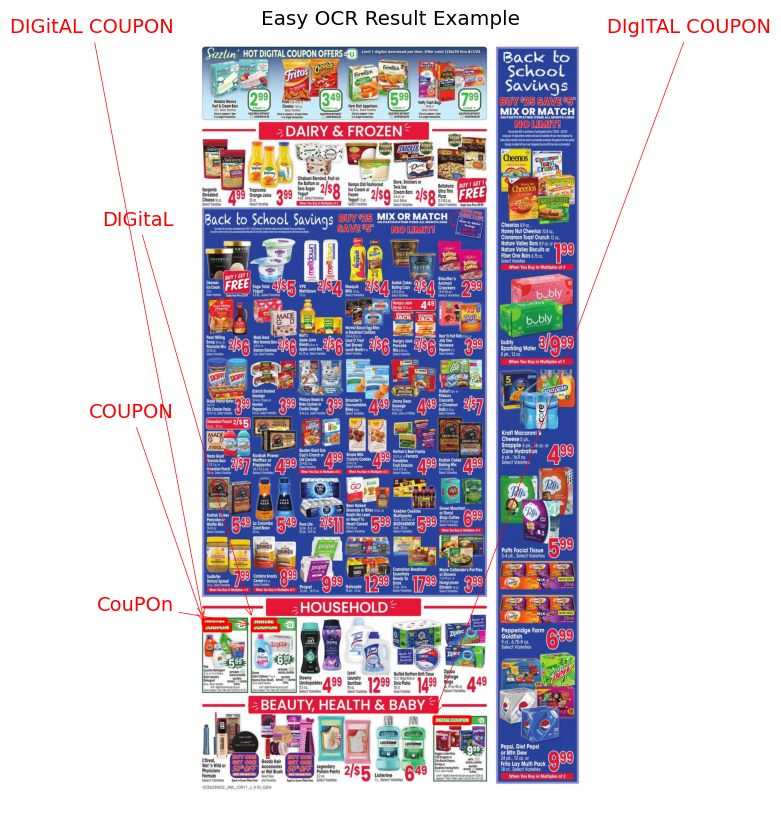

Skipping index 2 as the DataFrame is empty.
Skipping index 3 as the DataFrame is empty.
Skipping index 4 as the DataFrame is empty.
Algo has captured the target...
5


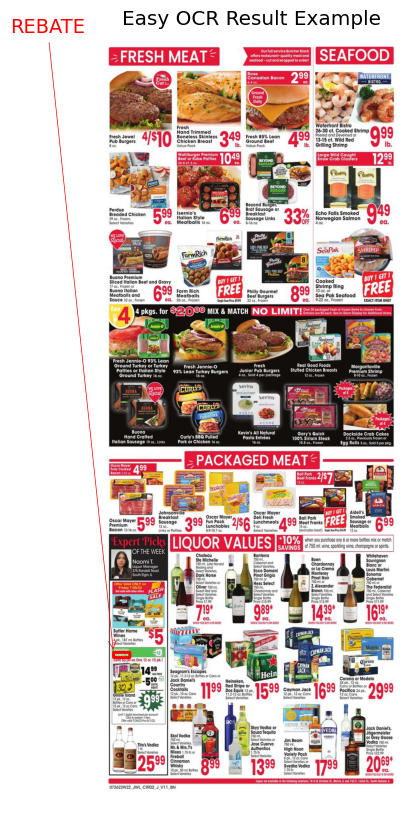

Algo has captured the target...
6


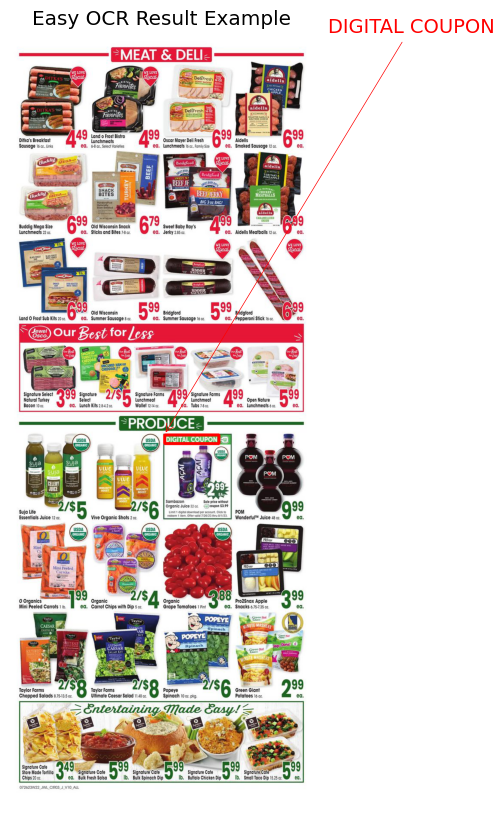

Skipping index 7 as the DataFrame is empty.
Algo has captured the target...
8


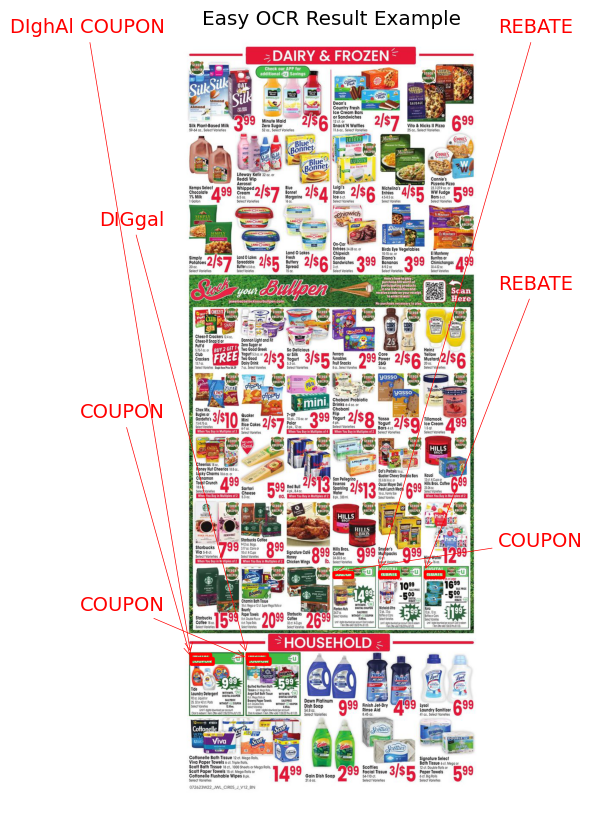

Skipping index 9 as the DataFrame is empty.
Algo has captured the target...
10


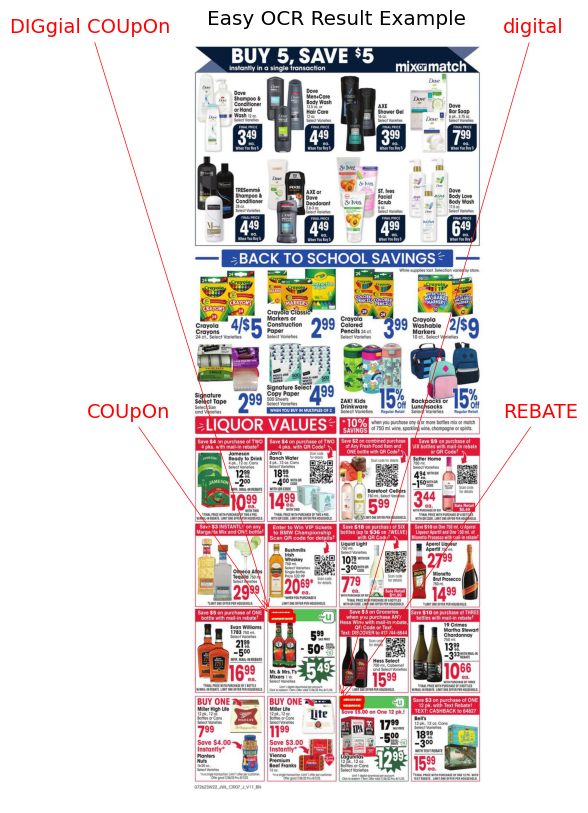

Skipping index 11 as the DataFrame is empty.
Skipping index 12 as the DataFrame is empty.


In [19]:
# df_repor = []
for index, img_path in enumerate(image_files):
    if not df123[index].empty:  # Check if the DataFrame is not empty
        print('Algo has captured the target...')
        print(index)
        plot_compare(img_path, df123[index], index)
        # filtered_df, grouped_df = merge_logic(dfs[index])
        # print(filtered_df)
        # df_report.append(filtered_df)
    else:
        print(f"Skipping index {index} as the DataFrame is empty.")
    # print(index, val)